In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
def download_daily_data(ticker, start, end):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """    
    return yf.download(ticker, start, end)

In [4]:
def compute_daily_returns(data):
    """ 
    The function computes daily log returns based on the Close prices in the pandas DataFrame
    and stores it in a column  called 'cc_returns'.
    """
    data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    return data

In [5]:
ticker = "MSFT"

In [6]:
start, end = datetime.date(2015, 1, 2), datetime.date(2020, 4, 30)

In [7]:
df = download_daily_data(ticker, start, end) # Download MSFT daily data from 2015-02-01 to 2020-04-30

[*********************100%***********************]  1 of 1 completed


In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.443684,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,41.062580,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.459892,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.973934,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,42.179317,29645200


In [9]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600


In [10]:
df = compute_daily_returns(df)
df.head()

,Open,High,Low,Close,Adj Close,Volume,cc_returns
Date,,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.443684,27913900,NaN
2015-01-05,46.369999,46.730000,46.250000,46.330002,41.062580,39673900,-0.009238
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.459892,36447900,-0.014786
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.973934,29114100,0.012625
2015-01-08,46.750000,47.750000,46.720001,47.590000,42.179317,29645200,0.028994


<div class="alert alert-info" style="margin: 10px"><strong>Q1 Solution</strong></div>

In [11]:
def q1_compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Big Moves on Mondays" trading strategy.
    Uses Adj Close price instead of Close price.
    """    
    # Calculate current day, previous day and four days after
    data['day'] = data.index.day_name()
    data['prev_day'] = data['day'].shift(1)
    data['four_days_after'] = data['day'].shift(-4)
    
    # Calculate 25 day relative range MA
    data['relative_range'] = (data['High'] - data['Low']) / data['Adj Close']
    data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()
    
    # Calculate intra-bar strength
    data['ibs'] = (data['Adj Close'] - data['Low']) / (data['High'] - data['Low'])
    
    return data

In [12]:
def q1_backtest_strategy(data, param2=0.25, param3=0.3):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Big Moves on Mondays" trading strategy. 
    It then computes the strategy returns.
    Uses Adj Close price instead of Close price.
    IMPORTANT: To be run ONLY after the function q1_compute_indicators.
    @params:
    param2: Parameter for condition2 -> multiply with rel_range_MA while calculating condition2
    param3: Parameter for condition3 -> compare with ibs while calculating condition3
    """
    data['condition1'] = np.where((data['day'] == 'Monday') 
                            & (data['prev_day'] == 'Friday') 
                            & (data['four_days_after'] == 'Friday'), 
                            1, 0)
    
    data['condition2'] = np.where((1 - data['Adj Close'] / data['Adj Close'].shift(1))
                                  >= param2 * data['rel_range_ma'], 1, 0)
    
    data['condition3'] = np.where(data['ibs'] < param3, 1, 0)
    
    data['signal'] = np.where((data['condition1']==1) 
                        & (data['condition2']==1) 
                        & (data['condition3']==1), 
                        1, 0)
    
    # The below two statements ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    data['signal'] = data['signal'].shift(1)
    
    data['position'] = data['signal'].replace(to_replace=0, method='ffill', limit=3)
    
    data['strategy_returns'] = data['cc_returns'] * data['position']
    
    return data

In [13]:
def show_backtesting_results(data):
    """
    The function displays the cumulative returns from the trading strategy and a buy-and-hold strategy. 
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run ONLY after the function q1_backtest_strategy.
    """
    print('Buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1], 2))
    print('Strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1], 2))
    
    data[['total_cc_returns', 'total_strategy_returns']] = data[['cc_returns', 'strategy_returns']].cumsum()
    data[['total_cc_returns', 'total_strategy_returns', 'position']].plot(
        secondary_y='position', grid=True, figsize=(12, 8))

In [14]:
dfq1 = df.copy() # Create fresh copy of price data

In [15]:
dfq1 = q1_compute_indicators(dfq1)
dfq1.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,day,prev_day,four_days_after,relative_range,rel_range_ma,ibs
Date,,,,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,Thursday,Wednesday,Wednesday,0.024456,0.041945,-0.292638
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,Friday,Thursday,NaN,0.022281,0.039679,0.541316
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,Monday,Friday,NaN,0.020894,0.037208,-0.278029
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,Tuesday,Monday,NaN,0.037358,0.036311,-0.205138
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,Wednesday,Tuesday,NaN,0.033021,0.035362,0.649152


In [16]:
dfq1_strat2 = dfq1.copy() # Keep backup for strategy rerun for different parameters

In [17]:
dfq1 = q1_backtest_strategy(dfq1) # Run strategy backtest with default parameters

Buy and hold returns:  1.33
Strategy returns:  0.73


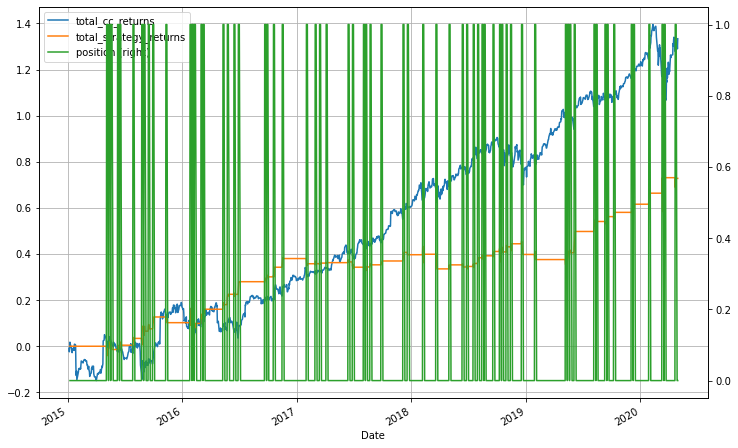

In [18]:
show_backtesting_results(dfq1)

In [19]:
dfq1_strat2 = q1_backtest_strategy(dfq1_strat2, param3=0.8) # Run strategy backtest with param3=0.8 -> ibs < 0.8

Buy and hold returns:  1.33
Strategy returns:  0.67


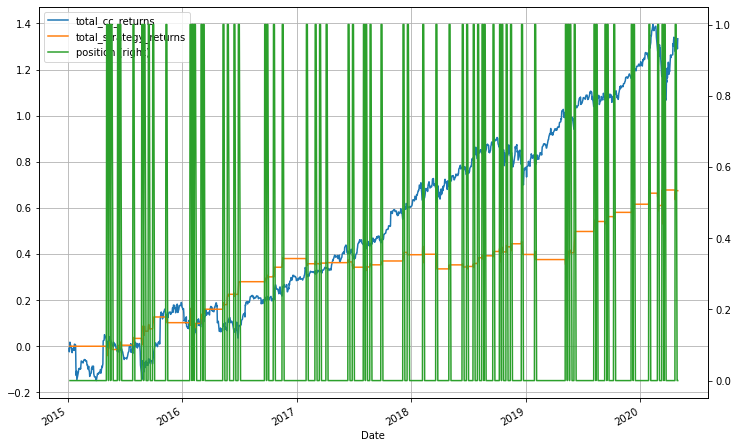

In [20]:
show_backtesting_results(dfq1_strat2)

<div class="alert alert-danger" style="margin: 10px">Strategy returns of 0.67 or 67% when ibs < 0.8 is worse than strategy returns of 0.76 or 76% when ibs < 0.3. Both are worse than buy & hold strategy returns of 1.33 or 133%.</div>

<div class="alert alert-info" style="margin: 10px"><strong>Q2 Solution</strong></div>

In [21]:
def q2_compute_indicators(data, n=20, k=2):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Bollinger Bands" trading strategy from question 2.
    Uses n-period Moving Average +/- k standard deviations of Adjusted Close price.
    @params:
    n: Period for which Bollinger bands indicator is to be calculated
    k: how many standard deviations from middle band should the outer bands be
    """    
    # Calculate middle band (n-period moving average)
    data['mid'] = data['Adj Close'].rolling(window=n).mean()
    
    # Calculate upper & lower bands
    std = data['Adj Close'].rolling(window=n).std()
    data['upper'] = data['mid'] + 2 * std
    data['lower'] = data['mid'] - 2 * std
    
    return data

In [22]:
def q2_backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Bollinger Bands" trading strategy from question 2.
    It then computes the strategy returns.
    Uses Adj Close price instead of Close price.
    IMPORTANT: To be run ONLY after the function q2_compute_indicators.
    """
    data['buy_cond'] = np.where((data['Adj Close'] < data['lower']) & (data['Adj Close'].shift(1) > data['lower'].shift(1)), 1, 0)
    
    data['sell_cond'] = np.where((data['Adj Close'] > data['upper']) & (data['Adj Close'].shift(1) < data['upper'].shift(1)), 1, 0)
    
    data['signal'] = np.where(data['buy_cond'] == 1, 1, 0) # Set to 1 on buy signal, 0 for others
    data['signal'] = np.where(data['sell_cond'] == 1, -1, data['signal']) # Set to -1 for sell signal, keep unchanged for others
    
    
    # The below two statements ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    data['signal'] = data['signal'].shift(1)
    
    data['position'] = data['signal'].replace(to_replace=0, method='ffill')
    
    data['strategy_returns'] = data['cc_returns'] * data['position']
    
    return data

In [23]:
dfq2 = df.copy()

In [24]:
dfq2 = q2_compute_indicators(dfq2)
dfq2.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,mid,upper,lower
Date,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,163.267371,180.582810,145.951933
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,164.180096,181.482898,146.877295
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,165.385349,181.302237,149.468461
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,165.859530,181.490041,150.229019
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,166.835610,182.343827,151.327394


In [25]:
dfq2 = q2_backtest_strategy(dfq2) # Run strategy backtest

<AxesSubplot:xlabel='Date'>

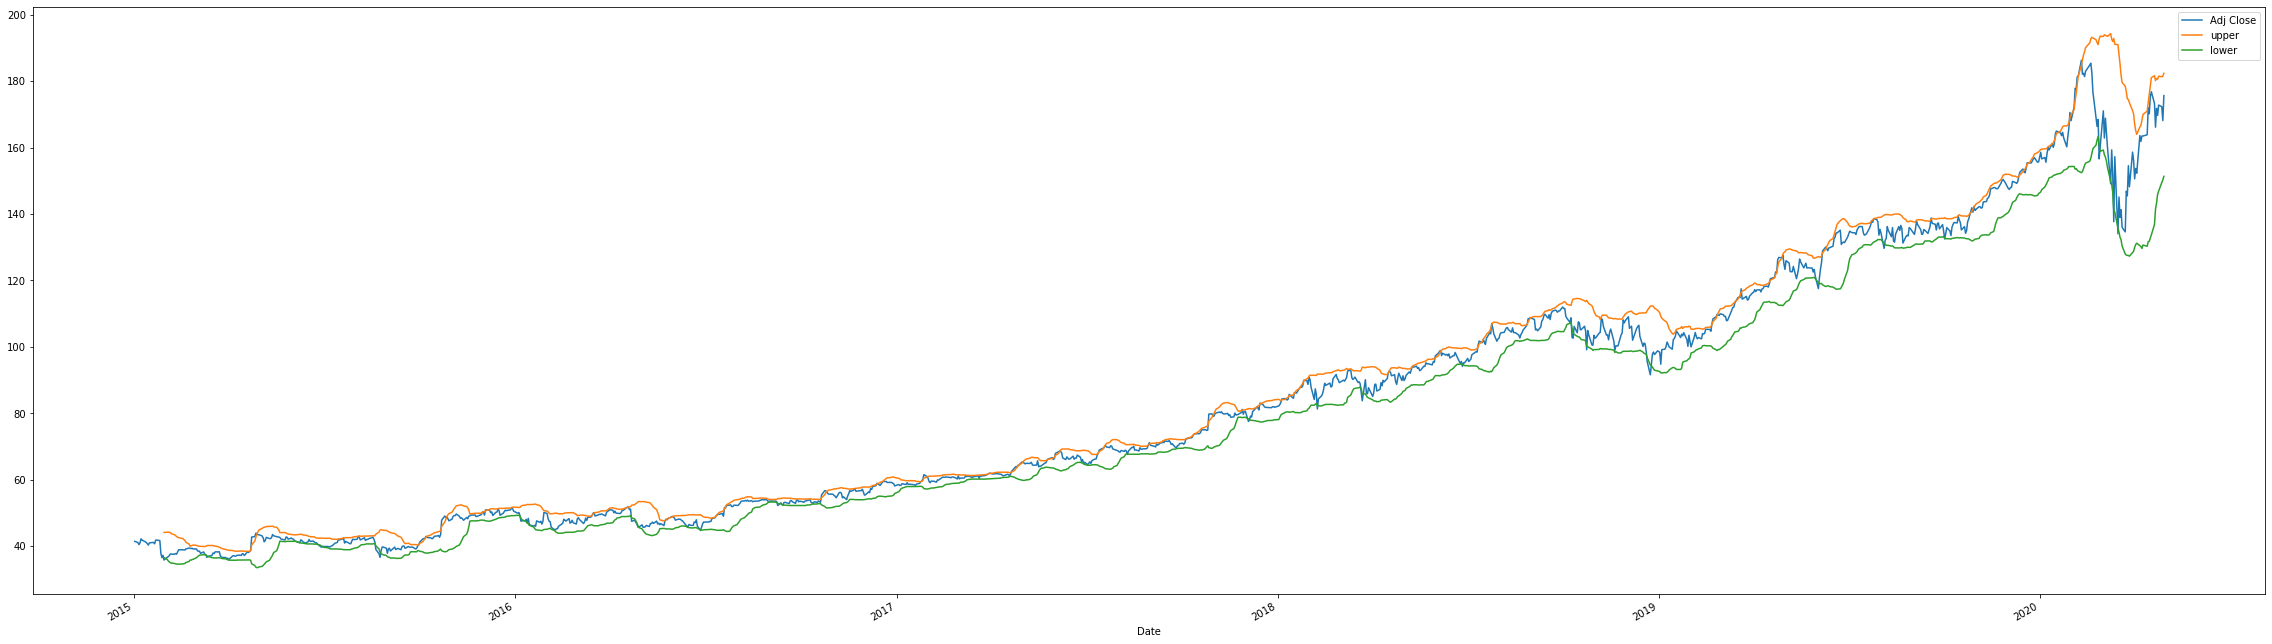

In [26]:
dfq2[['Adj Close', 'upper', 'lower']].plot(figsize=(40,12))

Buy and hold returns:  1.33
Strategy returns:  0.37


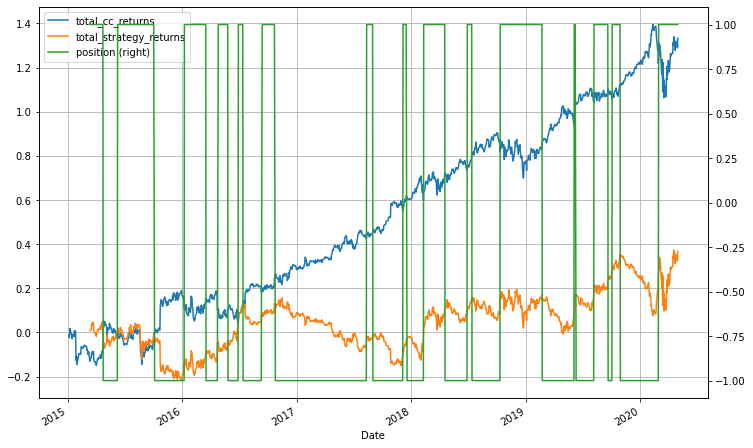

In [27]:
show_backtesting_results(dfq2)

<div class="alert alert-danger" style="margin: 10px">Strategy returns of 0.37 or 37% is poor compared to buy & hold returns of 1.33 or 133%. Strategy performs poorly because its a mean reversion strategy on daily timeframe when the market is trending.</div>

<div class="alert alert-info" style="margin: 10px"><strong>Q3 Solution</strong></div>

In [28]:
def q3_compute_indicators(data, n):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Exponential Moving Average" trading strategy from question 3.
    Uses Adjusted Close price.
    @params:
    n: Period for which Exponential Movong Average (EMA) is calculated
    """
    # Calculate n-period EMA
    data['ema'] = data['Adj Close'].ewm(span=n, adjust=False).mean()
    
    return data

In [29]:
def q3_backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Exponential Moving Average" trading strategy from question 3.
    It then computes the strategy returns.
    Uses Adj Close price instead of Close price.
    IMPORTANT: To be run ONLY after the function q3_compute_indicators.
    """
    data['position'] = np.where((data['Adj Close'] > data['ema']), 1, 0)
        
    # The below statement ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    data['position'] = data['position'].shift(1)
    
    data['strategy_returns'] = data['cc_returns'] * data['position']
    
    return data

In [30]:
def q3_find_optimal_returns(data, emalow, emahigh):
    """
    The function maximum strategy returns and optimal ema period for the EMA strategy from question 3.
    Returns maximum returns and corresponding ema period
    @params:
    emalow: minimum EMA period to be tested
    emahigh: maximum EMA period to be tested
    """   
    temp_data = dfq3.copy()
    max_returns, opt_ema = 0, 0
    for n in range(emalow, emahigh + 1):
        temp_data = q3_compute_indicators(temp_data, n)
        temp_data = q3_backtest_strategy(temp_data)
        strat_returns = np.round(temp_data['strategy_returns'].cumsum()[-1], 2)
        print(f'Strategy returns for EMA {n}: {strat_returns}')
        #ema = n if strat_returns > max_returns
        (max_returns, opt_ema) = (strat_returns, n) if strat_returns > max_returns else (max_returns, opt_ema)
    return max_returns, opt_ema

In [31]:
dfq3 = df.copy()

In [32]:
max_returns, opt_ema = q3_find_optimal_returns(dfq3, 1, 30) # Find optimal returns & EMA

Strategy returns for EMA 1: 0.0
Strategy returns for EMA 2: 0.09
Strategy returns for EMA 3: -0.1
Strategy returns for EMA 4: -0.06
Strategy returns for EMA 5: -0.2
Strategy returns for EMA 6: -0.2
Strategy returns for EMA 7: -0.15
Strategy returns for EMA 8: -0.28
Strategy returns for EMA 9: -0.18
Strategy returns for EMA 10: -0.05
Strategy returns for EMA 11: 0.16
Strategy returns for EMA 12: 0.19
Strategy returns for EMA 13: 0.24
Strategy returns for EMA 14: 0.35
Strategy returns for EMA 15: 0.32
Strategy returns for EMA 16: 0.27
Strategy returns for EMA 17: 0.24
Strategy returns for EMA 18: 0.26
Strategy returns for EMA 19: 0.25
Strategy returns for EMA 20: 0.22
Strategy returns for EMA 21: 0.12
Strategy returns for EMA 22: 0.12
Strategy returns for EMA 23: 0.07
Strategy returns for EMA 24: 0.09
Strategy returns for EMA 25: 0.18
Strategy returns for EMA 26: 0.2
Strategy returns for EMA 27: 0.15
Strategy returns for EMA 28: 0.18
Strategy returns for EMA 29: 0.15
Strategy returns for

In [33]:
print(f'--- Max strategy returns of {max_returns} when EMA = {opt_ema} ---')

--- Max strategy returns of 0.35 when EMA = 14 ---


In [34]:
dfq3 = q3_compute_indicators(dfq3, opt_ema)
dfq3.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,ema
Date,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,166.966496
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,167.743506
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,168.350919
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,168.317694
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,169.294679


In [35]:
dfq3 = q3_backtest_strategy(dfq3) # Run strategy backtest

In [36]:
dfq3.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,ema,position,strategy_returns
Date,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,166.966496,1.0,-0.012176
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,167.743506,1.0,0.018095
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,168.350919,1.0,-0.002869
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,168.317694,1.0,-0.024662
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,169.294679,0.0,0.000000


Buy and hold returns:  1.33
Strategy returns:  0.35


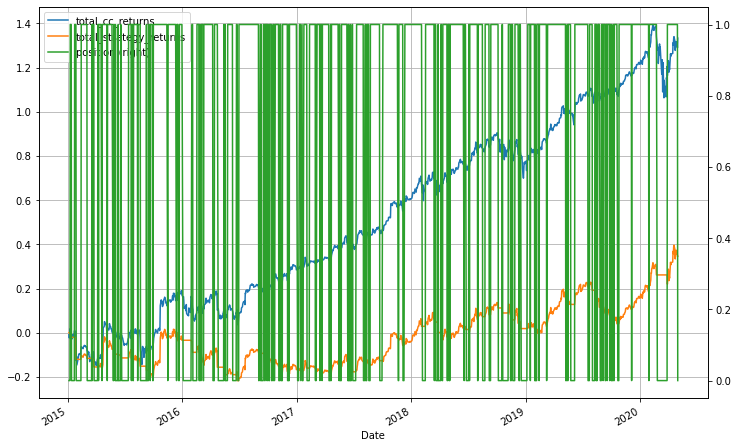

In [37]:
show_backtesting_results(dfq3)

<div class="alert alert-info" style="margin: 10px"><strong>Q4 Solution</strong></div>

In [38]:
def q4_compute_indicators(data, sma1=50, sma2=200):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Moving Average Crossover" trading strategy.
    Uses Adj Close price instead of Close price.
    @params:
    sma1: First moving average
    sma2: Second moving average
    """    
    # Calculate moving averages
    data['sma1'] = data['Adj Close'].rolling(window=sma1).mean()
    data['sma2'] = data['Adj Close'].rolling(window=sma2).mean()
    
    # Calculate previous day moving averages
    data['sma1_prev_day'] = data['sma1'].shift(1)
    data['sma2_prev_day'] = data['sma2'].shift(1)
    
    return data

In [39]:
def q4_backtest_strategy(data, long_only=False):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Bollinger Bands" trading strategy from question 2.
    It then computes the strategy returns.
    Uses Adj Close price instead of Close price.
    IMPORTANT: To be run ONLY after the function q2_compute_indicators.
    """    
    data['signal'] = np.where((data['sma1'] > data['sma2']) 
                            & (data['sma1_prev_day'] < data['sma2_prev_day']), 1, 0)
    data['signal'] = np.where((data['sma1'] < data['sma2']) 
                            & (data['sma1_prev_day'] > data['sma2_prev_day']), -1, data['signal'])
    
    
    # The below statements ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    data['signal'] = data['signal'].shift(1)
    
    data['position'] = data['signal'].replace(to_replace=0, method='ffill')
    if long_only: # Discard short positions
        data['position'] = data['position'].replace(to_replace=-1, value=0)

    data['strategy_returns'] = data['cc_returns'] * data['position']
    
    return data

In [40]:
df4 =df.copy()

In [41]:
dfq4 = q4_compute_indicators(df4)
dfq4.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,sma1,sma2,sma1_prev_day,sma2_prev_day
Date,,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,161.351571,149.161035,161.599404,148.981641
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,161.160377,149.349105,161.351571,149.161035
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,160.979028,149.532005,161.160377,149.349105
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,160.681350,149.691466,160.979028,149.532005
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,160.497419,149.888643,160.681350,149.691466


In [42]:
dfq4_longonly = dfq4.copy() # Keep backup for strategy rerun for long only strategy

In [43]:
dfq4 = q4_backtest_strategy(dfq4) # Run strategy backtest
dfq4.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,sma1,sma2,sma1_prev_day,sma2_prev_day,signal,position,strategy_returns
Date,,,,,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,161.351571,149.161035,161.599404,148.981641,0.0,1.0,-0.012176
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,161.160377,149.349105,161.351571,149.161035,0.0,1.0,0.018095
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,160.979028,149.532005,161.160377,149.349105,0.0,1.0,-0.002869
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,160.681350,149.691466,160.979028,149.532005,0.0,1.0,-0.024662
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,160.497419,149.888643,160.681350,149.691466,0.0,1.0,0.043896


Buy and hold returns:  1.33
Strategy returns:  0.94


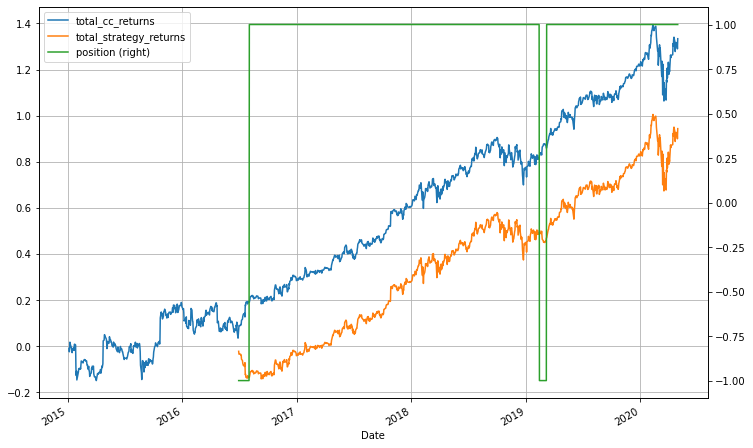

In [44]:
show_backtesting_results(dfq4)

In [45]:
dfq4_longonly = q4_backtest_strategy(dfq4_longonly, long_only=True) # Run strategy backtest
dfq4_longonly.tail()

,Open,High,Low,Close,Adj Close,Volume,cc_returns,sma1,sma2,sma1_prev_day,sma2_prev_day,signal,position,strategy_returns
Date,,,,,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,169.695557,32790800,-0.012176,161.351571,149.161035,161.599404,148.981641,0.0,1.0,-0.012176
2020-04-24,172.059998,174.559998,170.710007,174.550003,172.794067,34305300,0.018095,161.160377,149.349105,161.351571,149.161035,0.0,1.0,0.018095
2020-04-27,176.589996,176.899994,173.300003,174.050003,172.299103,33194400,-0.002869,160.979028,149.532005,161.160377,149.349105,0.0,1.0,-0.002869
2020-04-28,175.589996,175.669998,169.389999,169.809998,168.101730,34392700,-0.024662,160.681350,149.691466,160.979028,149.532005,0.0,1.0,-0.024662
2020-04-29,173.220001,177.679993,171.880005,177.429993,175.645081,51286600,0.043896,160.497419,149.888643,160.681350,149.691466,0.0,1.0,0.043896


Buy and hold returns:  1.33
Strategy returns:  1.11


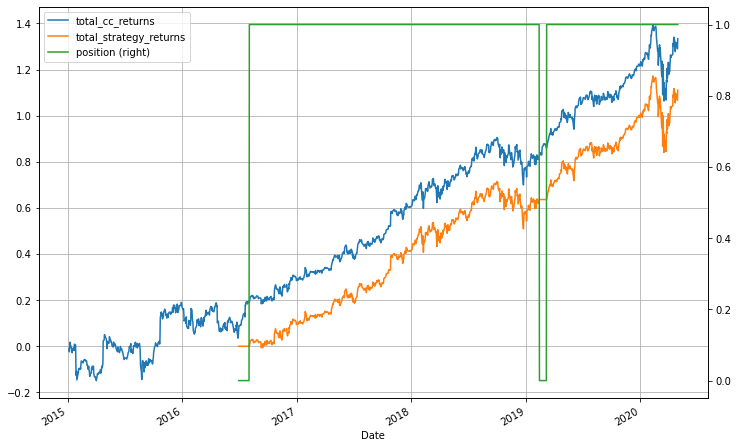

In [46]:
show_backtesting_results(dfq4_longonly)

In [47]:
plot_dfq4 = pd.DataFrame()
plot_dfq4[['total_cc_returns', 'total_longshort_strategy_returns']] =  dfq4[['cc_returns', 'strategy_returns']].cumsum()
plot_dfq4['total_longonly_strategy_returns'] =  dfq4_longonly['strategy_returns'].cumsum()

<AxesSubplot:xlabel='Date'>

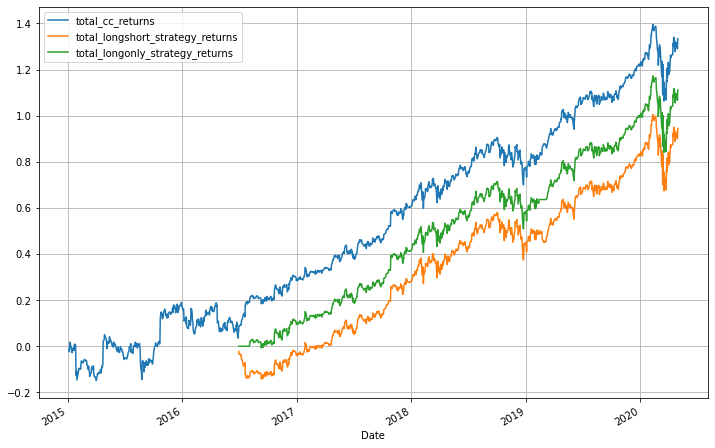

In [48]:
plot_dfq4.plot(grid=True, figsize=(12, 8))

<div class="alert alert-danger" style="margin: 10px">Long only strategy performed much better than the original long short strategy.</div>

<div class="alert alert-info" style="margin: 10px"><strong>Q5 Solution</strong></div>

In [49]:
tickers = ['TSLA', 'NFLX', 'AMZN', 'GOOG', 'CVX'] 

In [50]:
start, end = datetime.date(2015, 1, 1), datetime.date(2020, 4, 30)

In [51]:
data_multi = dict() # Dictionary to store all retrieved daily data

for ticker in tickers: # Download data for each ticker
    data_multi[ticker] = download_daily_data(ticker, start, end) # Download daily data from 2015-02-01 to 2020-04-30
    print(ticker, data_multi[ticker].head())

[*********************100%***********************]  1 of 1 completed
TSLA                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-12-31  44.618000  45.136002  44.450001  44.481998  44.481998  11487500
2015-01-02  44.574001  44.650002  42.652000  43.862000  43.862000  23822000
2015-01-05  42.910000  43.299999  41.431999  42.018002  42.018002  26842500
2015-01-06  42.012001  42.840000  40.841999  42.256001  42.256001  31309500
2015-01-07  42.669998  42.956001  41.956001  42.189999  42.189999  14842000
[*********************100%***********************]  1 of 1 completed
NFLX                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-12-31  49.032856  49.391430  48.787144  48.801430  48.801430   8627500
2015-01-02  49.151428  50.331429  48.731430  49.848572  49.848572  13475000
2015-01-05  49.2

In [52]:
# Calculate daily return, cumulative return and profit indicator for calculating hit ratio
for ticker in data_multi: # calculate for each ticker
    data_multi[ticker]['DailyReturn'] = (data_multi[ticker]['Close'] - data_multi[ticker]['Open']) / data_multi[ticker]['Open']
    data_multi[ticker]['CumulativeReturns'] = np.cumprod(1 + data_multi[ticker]['DailyReturn'])
    data_multi[ticker]['Profit?'] = np.where(data_multi[ticker]['DailyReturn'] > 1, 1, 0) # Store 1 if profitable trade, else store 0
    print(data_multi[ticker].head())

                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2014-12-31  44.618000  45.136002  44.450001  44.481998  44.481998  11487500   
2015-01-02  44.574001  44.650002  42.652000  43.862000  43.862000  23822000   
2015-01-05  42.910000  43.299999  41.431999  42.018002  42.018002  26842500   
2015-01-06  42.012001  42.840000  40.841999  42.256001  42.256001  31309500   
2015-01-07  42.669998  42.956001  41.956001  42.189999  42.189999  14842000   

            DailyReturn  CumulativeReturns  Profit?  
Date                                                 
2014-12-31    -0.003048           0.996952        0  
2015-01-02    -0.015973           0.981027        0  
2015-01-05    -0.020788           0.960634        0  
2015-01-06     0.005808           0.966213        0  
2015-01-07    -0.011249           0.955344        0  
                 Open       High        Low      Close  Adj Close   

In [53]:
# Print hit ratio of strategy for each ticker and create a dataframe with cumulative returns for all tickers
cum_ret_data = pd.DataFrame()
for ticker in tickers:
    cum_ret_data[ticker] = data_multi[ticker]['CumulativeReturns']
    hit_ratio = data_multi[ticker]['Profit?'].sum() / data_multi[ticker]['Profit?'].shape[0] # Count of profitable trades divided by total trades
    print(f'Hit Ratio for {ticker}: {np.round(hit_ratio, 2)}')

Hit Ratio for TSLA: 0.0
Hit Ratio for NFLX: 0.0
Hit Ratio for AMZN: 0.0
Hit Ratio for GOOG: 0.0
Hit Ratio for CVX: 0.0


In [54]:
cum_ret_data.head()

,TSLA,NFLX,AMZN,GOOG,CVX
Date,,,,,
2014-12-31,0.996952,0.995280,0.996148,0.990871,1.004747
2015-01-02,0.981027,1.009397,0.983210,0.983004,1.013298
2015-01-05,0.960634,0.969496,0.967773,0.965363,0.986997
2015-01-06,0.966213,0.952179,0.945520,0.940920,0.988461
2015-01-07,0.955344,0.940027,0.948444,0.929970,0.976609


<AxesSubplot:title={'center':'Cumulative returns'}, xlabel='Date'>

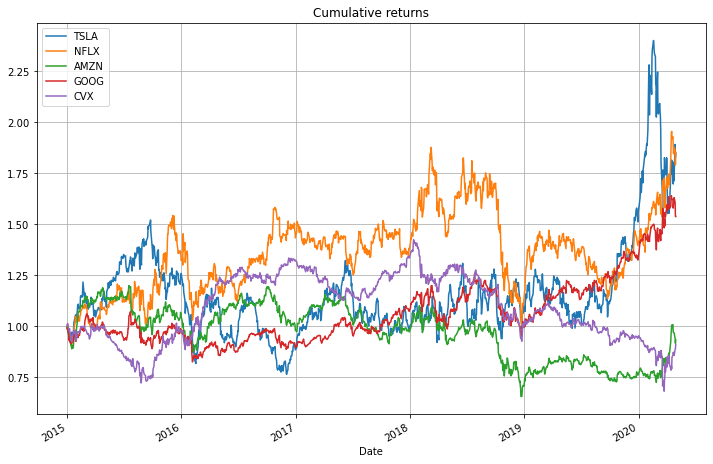

In [55]:
cum_ret_data.plot(figsize=(12, 8), grid=True, title='Cumulative returns')

<div class="alert alert-danger" style="margin: 10px">Hit ratio for all stocks is around 50% which suggests that each trade is like a coin toss for this strategy. The cumulative returns are also all over the place with some stocks showing negative returns while others show positive returns.</div>